In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_full = pd.read_csv('../reports/result_df_conv.csv')
df_full['name'] = df_full.T.apply(lambda row: '_'.join([str(x) for x in row.drop(['num', 'smape', 'mase*'])]))
print(df_full.shape)

# Keep ensembles
df = df_full[df_full['num'].isna()].dropna(axis=1)
print(df.shape)

# Filter out other input/output sequence lengths
df = df[(df['input_len'] == 18) & (df['output_len'] == 14)]
print(df.shape)

# Filter out duplicates (usually errors)
df = df[~df['name'].duplicated(keep='first')]
print(df.shape)

(9699, 15)
(159, 14)
(119, 14)
(119, 14)


In [3]:
def add_benchmarks(legend_loc=None):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.plot([-0.5, 350.5], [13.176, 13.176], ls='--', c='C3', label='M4 winner', lw=2)
    plt.plot([-0.5, 350.5], [12.913, 12.913], ls='--', c='C4', label='N-BEATS', lw=2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.legend(loc=legend_loc)
    
def keep_duplicates(df, column):
    
    gb = df.groupby(column)

    for group in gb.groups:
        try:
            mask.merge(gb.get_group(group).drop([column, 'smape', 'mase*'], axis=1), how='inner')
        except NameError:
            mask = gb.get_group(group).drop([column, 'smape', 'mase*'], axis=1)
            
    results = [gb.get_group(group).merge(mask) for group in gb.groups]
    
    return pd.concat(results)

## Comparison of all models

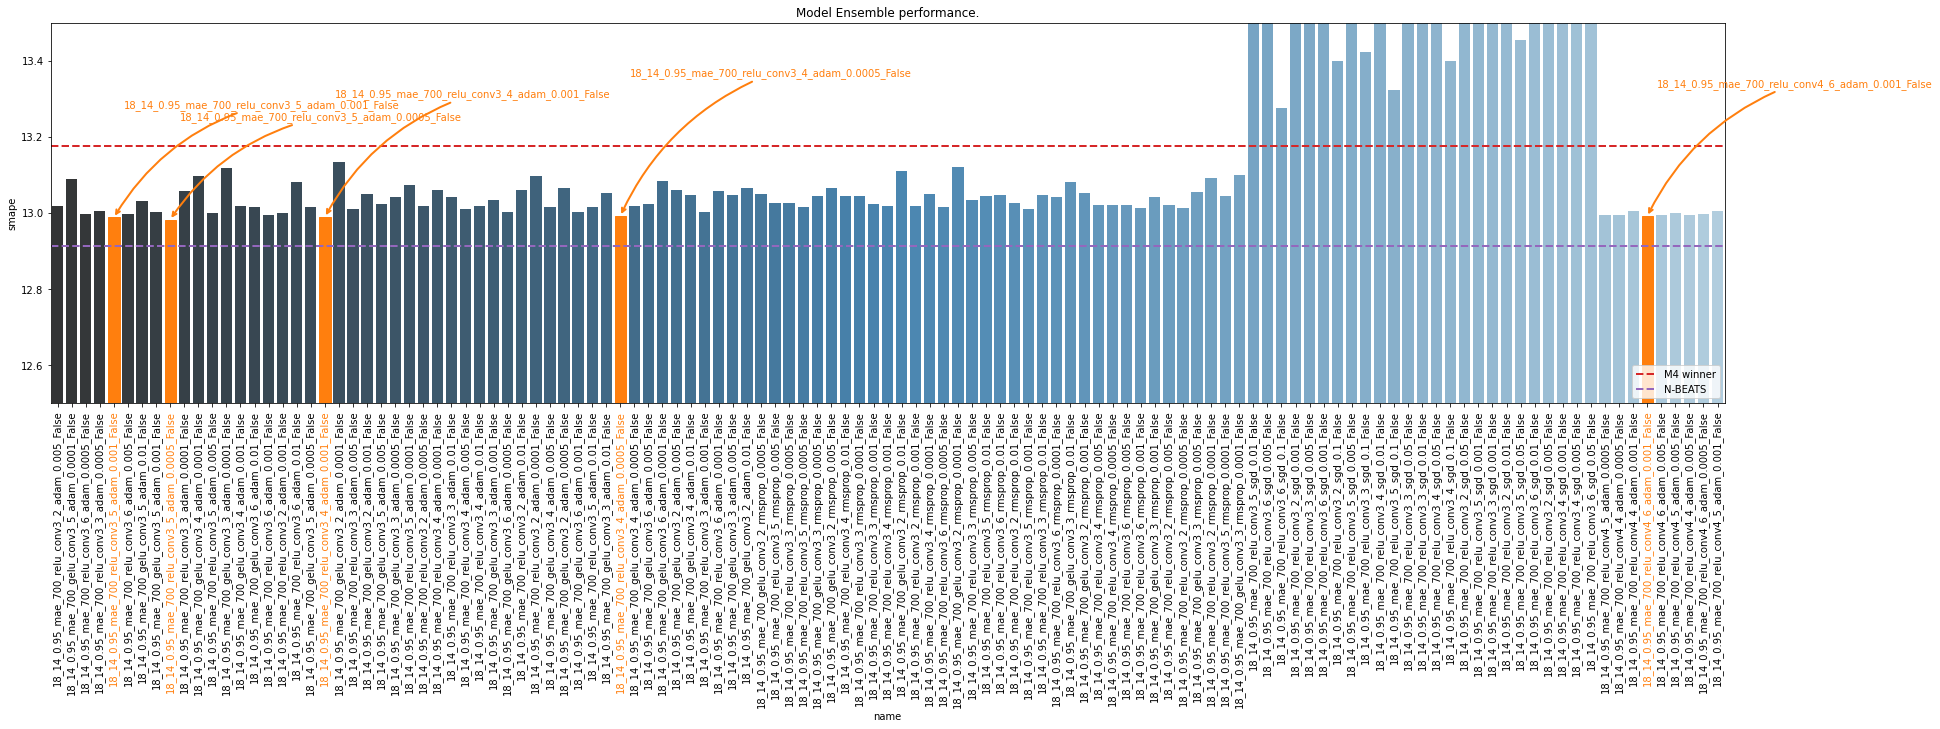

In [4]:
plt.figure(figsize=(30, 7))

top5 = df.reset_index().sort_values('smape')[:5].index

ax = sns.barplot(x='name', y='smape', data=df, palette='Blues_d')

[bar.set_color('C1') for bar in np.array(ax.get_children())[top5]]
[label.set_color('C1') for label in np.array(ax.get_xticklabels())[top5]]

for en, i in enumerate(top5):
    ax.annotate(df.iloc[i]['name'], (i, df.iloc[i]['smape']), 
                (10, 100+(en*10)), textcoords='offset points', c='C1',
                arrowprops={'arrowstyle': '->', 'color': 'C1',
                            'connectionstyle': 'arc3,rad=.2', 'lw': 2})

plt.title('Model Ensemble performance.')
plt.ylim([12.5, 13.5])

plt.xticks(rotation=90)

add_benchmarks(legend_loc='lower right')

## Show best

In [6]:
df.sort_values(by='smape').head()

,input_len,output_len,aug,loss,bottleneck_size,bottleneck_activation,model_type,kernel_size,optimizer,learning_rate,line,smape,mase*,name
548,18,14,0.95,mae,700,relu,conv3,5,adam,0.0005,False,12.982857,2.660828,18_14_0.95_mae_700_relu_conv3_5_adam_0.0005_False
304,18,14,0.95,mae,700,relu,conv3,5,adam,0.0010,False,12.988307,2.659835,18_14_0.95_mae_700_relu_conv3_5_adam_0.001_False
1219,18,14,0.95,mae,700,relu,conv3,4,adam,0.0010,False,12.989569,2.659663,18_14_0.95_mae_700_relu_conv3_4_adam_0.001_False
9393,18,14,0.95,mae,700,relu,conv4,6,adam,0.0010,False,12.991585,2.660392,18_14_0.95_mae_700_relu_conv4_6_adam_0.001_False
2500,18,14,0.95,mae,700,relu,conv3,4,adam,0.0005,False,12.992399,2.661416,18_14_0.95_mae_700_relu_conv3_4_adam_0.0005_False


## Activation

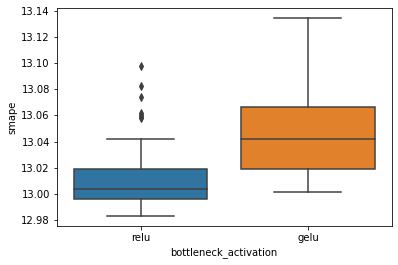

In [7]:
sns.boxplot(x='bottleneck_activation', y='smape', data=df[df['optimizer'] == 'adam'])

### Keep only ReLU results

In [8]:
df2 = df[df['bottleneck_activation'] == 'relu']

## Optimizer

(12.8, 13.2)

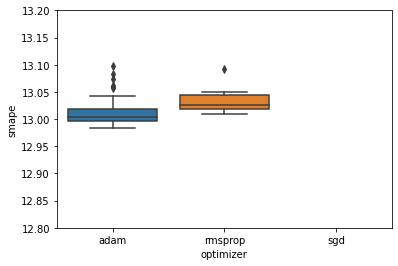

In [9]:
ax = sns.boxplot(x='optimizer', y='smape', data=df2)
ax.set_ylim([12.8, 13.2])

### Keep only results for Adam

In [10]:
df3 = df2[df2['optimizer'] == 'adam']

## Kernel size

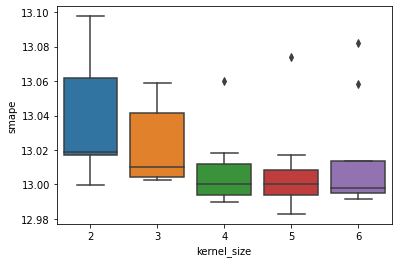

In [11]:
sns.boxplot(x='kernel_size', y='smape', data=df3)

## Learning Rate

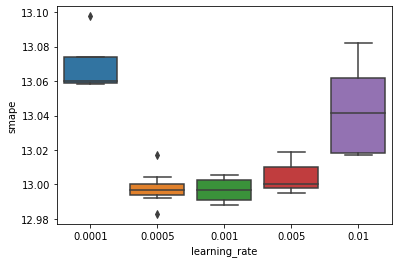

In [21]:
sns.boxplot(x='learning_rate', y='smape', data=df3)

## Conv size

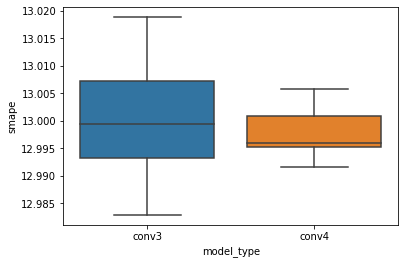

In [24]:
sns.boxplot(x='model_type', y='smape', data=df3[(df3['learning_rate'] >= 0.0005) & (df3['learning_rate'] <= 0.005)])

## Investigate warm/cold reststarts

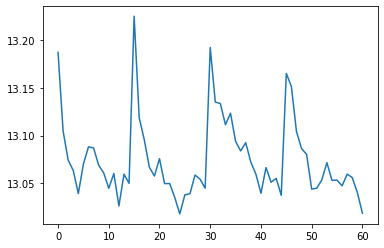

In [13]:
n = df_full['name'][0]
plt.plot(df_full[df_full['name'] == n]['smape'])

Runs involving Adam did **not** have warmup phase.

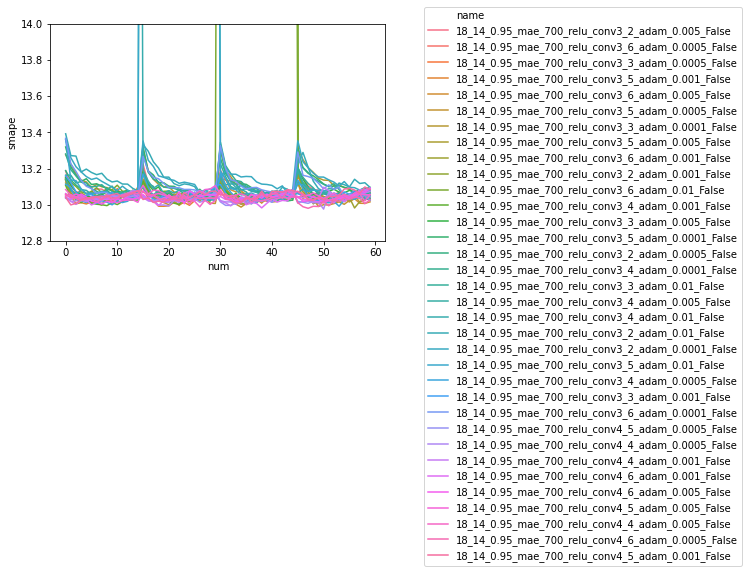

In [14]:
sns.lineplot(x='num', y='smape', hue='name',
             data=df_full[(df_full['bottleneck_activation'] == 'relu') & 
                          (df_full['optimizer'] == 'adam')])
plt.ylim([12.8, 14])
plt.legend(bbox_to_anchor=(1.1, 1.1))

Runs involving RMSProp **did** have a warmup phase.

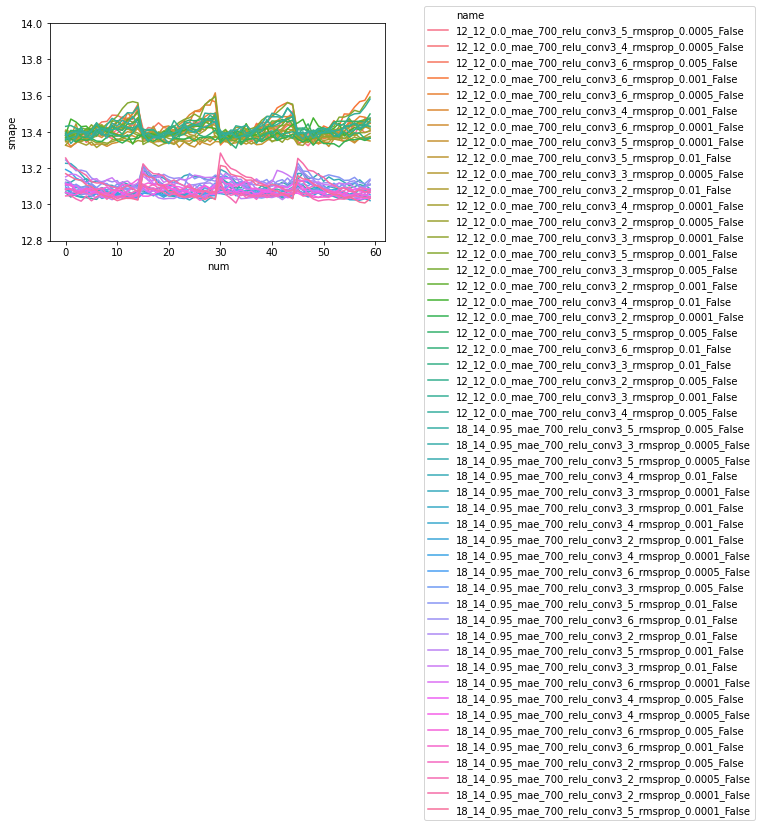

In [15]:
sns.lineplot(x='num', y='smape', hue='name',
             data=df_full[(df_full['bottleneck_activation'] == 'relu') & 
                          (df_full['optimizer'] == 'rmsprop')])
plt.ylim([12.8, 14])
plt.legend(bbox_to_anchor=(1.1, 1.1))